In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

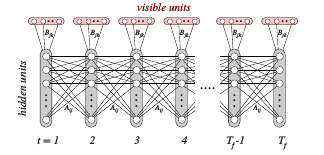

Fig.11: A Hidden Markov Model can be “unfolded” in time to show a trellis, which can be represented as a Boltzmann chain, as shown. The discrete hidden states are grouped into vertical sets, fully interconnected by weights $A_(ij)$ (related to the HMM transition probabilities aij ). The discrete visible states are grouped into horizontal sets, and are fully interconnected with the hidden states by weights $B_jk$ (related to transition probabilities $b_jk$ ). Training the net with a single pattern, or list of Tf visible states, consists of clamping the visible states and performing Boltzmann learning throughout the full network, with the constraint that each of the time shifted weights labeled by a particular $A_ij$ have the same numerical value.

## Boltzmann Networks and Graphical Models

### Boltzmann Networks and Graphical Models

While we have considered fully interconnected Boltzmann networks, the learning algorithm (Algorithm 3) applies equally well to networks with arbitrary connection topologies. Furthermore, it is easy to modify Boltzmann learning in order to impose constraints such as weight sharing. As a consequence, several popular recognition architectures—so-called graphical models such as Bayesian belief networks and Hidden Markov Models—have counterparts in structured Boltzmann networks, leading to new methods for training them.

Recall from Chapter ?? that Hidden Markov Models (HMMs) consist of several discrete hidden and visible states. At each discrete time step $t$, the system is in a single hidden state and emits a single visible state, denoted $\omega(t)$ and $v(t)$, respectively. The transition probabilities between hidden states at successive time steps are:

$$
a_{ij} = P(\omega_j(t + 1) | \omega_i(t)) \tag{19}$$

and between hidden and visible states at a given time are:

$$
b_{jk} = P(v_k(t) | \omega_j(t)). \tag{20}$$

The Forward-Backward or Baum-Welch algorithm (Chapter ??, Algorithm ??) is traditionally used for learning these parameters from a pattern of $T_f$ visible states:

$$
V_{T_f} = \{v(1), v(2), \dots, v(T_f)\}.
$$

> **Note**: Here we use $T_f$ to count the number of discrete time steps in order to avoid confusion with the temperature $T$ in Boltzmann simulations.

---

### HMM Trellis Representation

A Hidden Markov Model can be “unfolded” in time to show a trellis, which can be represented as a Boltzmann chain, as shown in Figure 7.11:

- The discrete hidden states are grouped into vertical sets, fully interconnected by weights $A_{ij}$ (related to the HMM transition probabilities $a_{ij}$).
- The discrete visible states are grouped into horizontal sets and are fully interconnected with the hidden states by weights $B_{jk}$ (related to transition probabilities $b_{jk}$).

Training the network with a single pattern, or list of $T_f$ visible states, consists of clamping the visible states and performing Boltzmann learning throughout the full network, with the constraint that each of the time-shifted weights labeled by a particular $A_{ij}$ have the same numerical value.

---

### Boltzmann Chain Representation

A structured Boltzmann network with the same trellis topology—a **Boltzmann chain**—can be used to implement the same classification as the corresponding Hidden Markov Model (Figure 7.11). Although it is often simpler to work in a representation where discrete states have multiple values, we temporarily work in a representation where the binary nodes take value $s_i = 0$ or $+1$, rather than $\pm1$ as in previous discussions.

In this representation, a special case of the general energy includes terms for a particular sequence of visible states $V_{T_f}$ and hidden states $\omega_{T_f} = \{\omega(1), \omega(2), \dots, \omega(T_f)\}$:

$$
E_{\omega, V} = E[\omega_{T_f}, V_{T_f}] = - \sum_{t=1}^{T_f - 1} A_{ij} - \sum_{t=1}^{T_f} B_{jk}, \tag{21}
$$

where the particular values of $A_{ij}$ and $B_{jk}$ terms depend implicitly upon the sequence. The choice of binary state representation implies that only the weights linking nodes that both have $s_i = +1$ appear in the energy. Each “legal” configuration—consisting of a single visible unit and a single hidden unit at each time—implies a set of $A_{ij}$ and $B_{jk}$ (Problem 20).

The partition function is the sum over all legal states:

$$
Z = \sum_{\omega, V} e^{-E_{\omega, V} / T}, \tag{22}
$$

which ensures normalization.

The correspondence between the Boltzmann chain at temperature $T$ and the unfolded Hidden Markov model (trellis) implies:

$$
A_{ij} = T \ln a_{ij}, \quad B_{jk} = T \ln b_{jk}. \tag{23}
$$

> **Note**: As in our discussion of Hidden Markov Models, we assume the initial hidden state is known, and thus there is no need to consider the correspondence of prior probabilities in the two approaches.

---

### Binary vs. Bipolar Representations

While the $0 \text{-} 1$ binary representation of states in the structured network clarifies the relationship to Hidden Markov Models through Equation (21), the more familiar representation $s_i = \pm 1$ works as well. Weights in the structured Boltzmann network are trained according to the method of Section 7.3, though the relation to transition probabilities in a Hidden Markov Model is no longer simple (Problem 21).


In [6]:
#Here is an implementation of the Boltzmann chain representation for a simplified Hidden Markov Model:


import numpy as np

class BoltzmannChain:
    def __init__(self, num_hidden, num_visible, temperature=1.0):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.temperature = temperature
        self.A = np.random.randn(num_hidden, num_hidden)  # Transition weights
        self.B = np.random.randn(num_hidden, num_visible)  # Emission weights

    def energy(self, hidden_states, visible_states):
        energy = 0
        # Transition energy
        for t in range(len(hidden_states) - 1):
            energy -= np.sum(self.A[hidden_states[t], hidden_states[t + 1]])
        # Emission energy
        for t in range(len(visible_states)):
            energy -= np.sum(self.B[hidden_states[t], visible_states[t]])
        return energy

    def partition_function(self, hidden_states, visible_states):
        legal_states = self.generate_legal_states(hidden_states, visible_states)
        return sum(np.exp(-self.energy(h, v) / self.temperature) for h, v in legal_states)

    def generate_legal_states(self, hidden_states, visible_states):
        # Generate all legal configurations for given sequences
        legal_states = []
        for h in range(self.num_hidden):
            for v in range(self.num_visible):
                legal_states.append((h, v))
        return legal_states

    def train(self, visible_sequence):
        hidden_states = np.random.randint(0, self.num_hidden, len(visible_sequence))
        for epoch in range(100):  # Simplified training loop
            grad_A, grad_B = self.compute_gradients(hidden_states, visible_sequence)
            self.A -= grad_A
            self.B -= grad_B

    def compute_gradients(self, hidden_states, visible_states):
        grad_A = np.zeros_like(self.A)
        grad_B = np.zeros_like(self.B)
        # Compute gradients (placeholder logic for illustration)
        return grad_A, grad_B

# Example usage
num_hidden = 3
num_visible = 3
temperature = 1.0
visible_sequence = [0, 1, 2, 1, 0]

model = BoltzmannChain(num_hidden, num_visible, temperature)
model.train(visible_sequence)

